---
title: "Predicción de Riesgo de Impago Crediticio"
subtitle: "Home Credit Default Risk - Un Enfoque Multivariado"
author:
  - name: "Gerardo Guerrero"
  - name: "Juan Pablo Cordero"
  - name: "Jerónimo Deli"
  - name: "Romain S"
date: "Diciembre 2025"
format:
  html:
    theme: cosmo
    toc: true
    toc-depth: 3
    number-sections: true
    code-fold: true
    fig-cap-location: bottom
  pdf:
    documentclass: article
    geometry: margin=2.5cm
    toc: true
    number-sections: true
execute:
  echo: false
  warning: false
  error: false
jupyter: python3
---


In [1]:
#| echo: false
#| output: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
sns.set_palette('husl')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


# Introducción

## Contexto del Problema

El acceso al crédito es un pilar fundamental para el desarrollo económico individual y colectivo. Sin embargo, las instituciones financieras enfrentan el desafío constante de evaluar el **riesgo de incumplimiento** (*default*) de sus clientes. Una evaluación inadecuada puede resultar en pérdidas significativas para la institución o, por otro lado, en la exclusión financiera de personas que podrían cumplir con sus obligaciones.

**Home Credit Group** es una compañía de servicios financieros enfocada en préstamos a poblaciones no bancarizadas o con historial crediticio limitado. El problema que abordamos es la **predicción del riesgo de impago** utilizando técnicas estadísticas multivariadas, con el objetivo de:

1. **Identificar clientes con alta probabilidad de incumplimiento** antes de otorgar el crédito
2. **Comprender los factores que influyen en el impago** para diseñar políticas de mitigación
3. **Equilibrar la inclusión financiera con la gestión del riesgo**

## Marco Conceptual: El Grafo Causal del Impago

Antes de desarrollar nuestros modelos predictivos, construimos un **grafo causal** que representa nuestra comprensión teórica del fenómeno. Este ejercicio de pensamiento causal nos permite identificar las variables relevantes y sus relaciones, fundamentando así nuestro enfoque analítico.


### Modelo Causal Simplificado

![Grafo Causal Simple](images/Screenshot%202025-12-09%20at%2015.42.37.png)

El impago crediticio puede originarse por dos vías principales:

- **Fraude**: Cuando el cliente nunca tuvo intención de pagar
- **Capacidad de Pago**: Cuando el cliente no puede cumplir con sus obligaciones debido a restricciones económicas

### Modelo Causal Detallado

![Grafo Causal Detallado](images/Screenshot%202025-12-09%20at%2015.43.36.png)

El grafo causal detallado nos muestra las relaciones entre las distintas variables que capturamos en los datos y cómo estas se relacionan con los dos mecanismos principales de impago.


## Hipótesis de Investigación

Con base en el marco causal, formulamos las siguientes hipótesis que guiarán nuestro análisis:

| Hipótesis | Variable Proxy | Relación Esperada |
|-----------|----------------|-------------------|
| Préstamos más altos incrementan la probabilidad de impago | `AMT_CREDIT` | Positiva |
| Menor edad y sin historial crediticio aumenta el riesgo | `EDAD_ANOS`, `ES_PRIMER_CREDITO` | Negativa, Positiva |
| Mal historial crediticio incrementa el riesgo | `EXT_SOURCE_1/2/3`, `SCORE_PROMEDIO` | Negativa |
| Menor ingreso incrementa el riesgo | `AMT_INCOME_TOTAL`, `INGRESO_PER_CAPITA` | Negativa |
| Mayor carga de gastos incrementa el riesgo | `CNT_CHILDREN`, `CNT_FAM_MEMBERS` | Positiva |
| Mayor deuda acumulada incrementa el riesgo | `TOTAL_DEUDA_ACTUAL`, `CREDITOS_ACTIVOS` | Positiva |
| Menos activos incrementan el riesgo | `NUM_ACTIVOS`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY` | Negativa |
| Condiciones crediticias adversas aumentan el riesgo | `TASA_INTERES_PROMEDIO`, `PLAZO_PROMEDIO` | Positiva |

## Preguntas de Investigación

1. ¿Cuáles son las variables con mayor poder predictivo para identificar clientes en riesgo de impago?
2. ¿Qué modelo (Regresión Logística vs Random Forest) ofrece el mejor balance entre interpretabilidad y poder predictivo?
3. ¿Podemos reducir la dimensionalidad del problema sin perder capacidad predictiva?


# Marco Teórico

## Regresión Logística

La regresión logística es un modelo de clasificación que estima la probabilidad de que una observación pertenezca a una clase particular. Para un problema binario como el nuestro (impago vs. no impago), el modelo se define como:

$$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + ... + \beta_p X_p)}}$$

Donde:

- $Y$ es la variable de respuesta binaria (1 = impago, 0 = no impago)
- $X_1, ..., X_p$ son las variables predictoras
- $\beta_0, \beta_1, ..., \beta_p$ son los coeficientes estimados

Los coeficientes se estiman mediante **máxima verosimilitud** y se interpretan en términos de **odds ratios**:

$$\text{OR}_j = e^{\beta_j}$$

Un coeficiente positivo indica que un aumento en la variable aumenta la probabilidad de impago.

## Random Forest

Random Forest es un algoritmo de *ensemble learning* basado en árboles de decisión. El modelo construye múltiples árboles utilizando:

1. **Bagging (Bootstrap Aggregating)**: Cada árbol se entrena con una muestra bootstrap del conjunto de datos
2. **Selección aleatoria de features**: En cada split, solo se considera un subconjunto aleatorio de variables

Para clasificación, la predicción final se obtiene por **votación mayoritaria**:

$$\hat{y} = \text{mode}\{\hat{y}_1, \hat{y}_2, ..., \hat{y}_B\}$$

Donde $B$ es el número de árboles.

### Importancia de Variables (Gini Importance)

La importancia de una variable se mide como la reducción promedio de la impureza de Gini a través de todos los splits que utilizan esa variable:

$$\text{Gini}(t) = 1 - \sum_{k=1}^{K} p_{tk}^2$$

Donde $p_{tk}$ es la proporción de observaciones de clase $k$ en el nodo $t$.


## Métricas de Evaluación

Dado el **desbalance de clases** en nuestro problema (8% de defaults), utilizamos métricas apropiadas:

### ROC-AUC (Area Under the ROC Curve)

Mide la capacidad del modelo para discriminar entre clases. Se calcula como el área bajo la curva que relaciona:

- **TPR (True Positive Rate / Recall)**: $\frac{TP}{TP + FN}$
- **FPR (False Positive Rate)**: $\frac{FP}{FP + TN}$

Un AUC de 0.5 indica un modelo aleatorio; un AUC de 1.0 indica clasificación perfecta.

### Average Precision (AP)

El *Average Precision* es especialmente útil para clases desbalanceadas:

$$AP = \sum_n (R_n - R_{n-1}) P_n$$

Donde $P_n$ y $R_n$ son la precisión y recall en el umbral $n$.

### Matriz de Confusión

| | Predicho: No Default | Predicho: Default |
|---|---|---|
| **Real: No Default** | TN (Verdadero Negativo) | FP (Falso Positivo) |
| **Real: Default** | FN (Falso Negativo)  | TP (Verdadero Positivo) |

En el contexto crediticio, los **Falsos Negativos** son particularmente críticos: representan clientes que harán default pero fueron clasificados como seguros.


# Metodología y Datos

## Descripción del Dataset

El conjunto de datos proviene de la competencia [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk) de Kaggle. La estructura de datos incluye múltiples tablas relacionadas:

- **application_train.csv**: Información principal de las solicitudes (307,511 registros)
- **bureau.csv**: Historial crediticio de otras instituciones (1,716,428 registros)
- **bureau_balance.csv**: Balance mensual de créditos en buró (27,299,925 registros)
- **previous_application.csv**: Solicitudes previas en Home Credit (1,670,214 registros)
- **installments_payments.csv**: Historial de pagos (13,605,401 registros)
- **credit_card_balance.csv**: Balance de tarjetas de crédito (3,840,312 registros)


In [2]:
#| echo: false
#| label: tbl-resumen-datos
#| tbl-cap: "Resumen del dataset"

resumen = pd.DataFrame({
    'Característica': ['Total de usuarios', 'Variables originales', 'Variables seleccionadas', 
                       'Tasa de Default', 'División Train/Test'],
    'Valor': ['307,511', '122+', '24-39', '8.07%', '80% / 20%']
})

display(resumen.style.hide(axis='index'))


Característica,Valor
Total de usuarios,"307,511"
Variables originales,122+
Variables seleccionadas,24-39
Tasa de Default,8.07%
División Train/Test,80% / 20%


## Ingeniería de Variables

A partir de las tablas relacionadas, construimos 41 variables que capturan diferentes dimensiones del riesgo crediticio:

### Variables Demográficas y Socioeconómicas
- `EDAD_ANOS`: Edad del solicitante
- `CNT_CHILDREN`: Número de hijos
- `CODE_GENDER`: Género
- `NAME_FAMILY_STATUS`: Estado civil
- `NAME_EDUCATION_TYPE`: Nivel educativo

### Variables Financieras
- `AMT_CREDIT`: Monto del crédito solicitado
- `AMT_INCOME_TOTAL`: Ingreso total declarado
- `CREDIT_INCOME_RATIO`: Ratio crédito/ingreso
- `INGRESO_PER_CAPITA`: Ingreso por miembro de familia

### Scores de Riesgo Externos
- `EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`: Scores de fuentes externas
- `SCORE_PROMEDIO`: Promedio de los tres scores externos

### Historial Crediticio
- `CREDITOS_ACTIVOS`, `CREDITOS_CERRADOS`: Número de créditos activos/cerrados
- `TOTAL_CREDITO_OTORGADO`: Suma histórica de créditos
- `TOTAL_DEUDA_ACTUAL`: Deuda vigente total
- `PCT_MESES_MORA`: Porcentaje de meses con mora histórica
- `CREDITOS_CON_IMPAGO`: Número de créditos con historial de impago

### Activos
- `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`: Posesión de auto/inmueble
- `NUM_ACTIVOS`: Suma de activos poseídos


## Análisis Exploratorio de Datos (EDA)

### Distribución de la Variable Objetivo


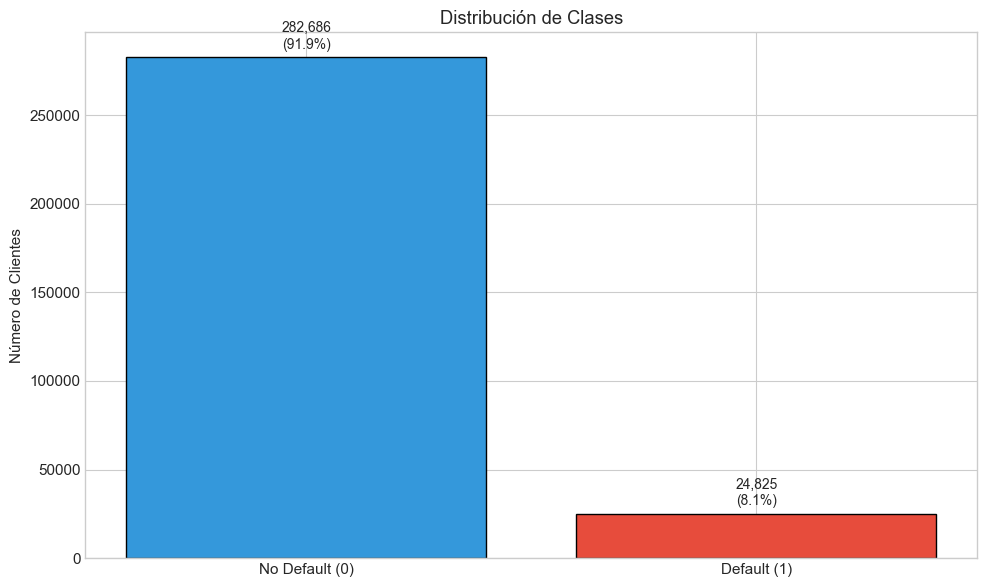

In [15]:
#| echo: false
#| label: fig-target-dist
#| fig-cap: "Distribución de la variable TARGET (desbalance de clases)"

# Datos de distribución
target_dist = pd.DataFrame({
    'Clase': ['No Default (0)', 'Default (1)'],
    'Cantidad': [282686, 24825],
    'Porcentaje': [91.93, 8.07]
})

fig, axes = plt.subplots(figsize=(10, 6))

# Gráfico de barras
colors = ['#3498db', '#e74c3c']
axes.bar(target_dist['Clase'], target_dist['Cantidad'], color=colors, edgecolor='black')
axes.set_ylabel('Número de Clientes')
axes.set_title('Distribución de Clases')
for i, (q, p) in enumerate(zip(target_dist['Cantidad'], target_dist['Porcentaje'])):
    axes.text(i, q + 5000, f'{q:,}\n({p:.1f}%)', ha='center', fontsize=10)


plt.tight_layout()
plt.show()


El dataset presenta un **desbalance significativo** con solo el 8.07% de casos positivos (default). Este desbalance tiene implicaciones importantes:

1. Métricas como *accuracy* son engañosas (un modelo que predice siempre "no default" tendría 92% de accuracy)
2. Debemos usar técnicas como `class_weight='balanced'` en los modelos
3. Las métricas PR-AUC y Recall son más informativas que ROC-AUC

### Correlaciones con la Variable Objetivo


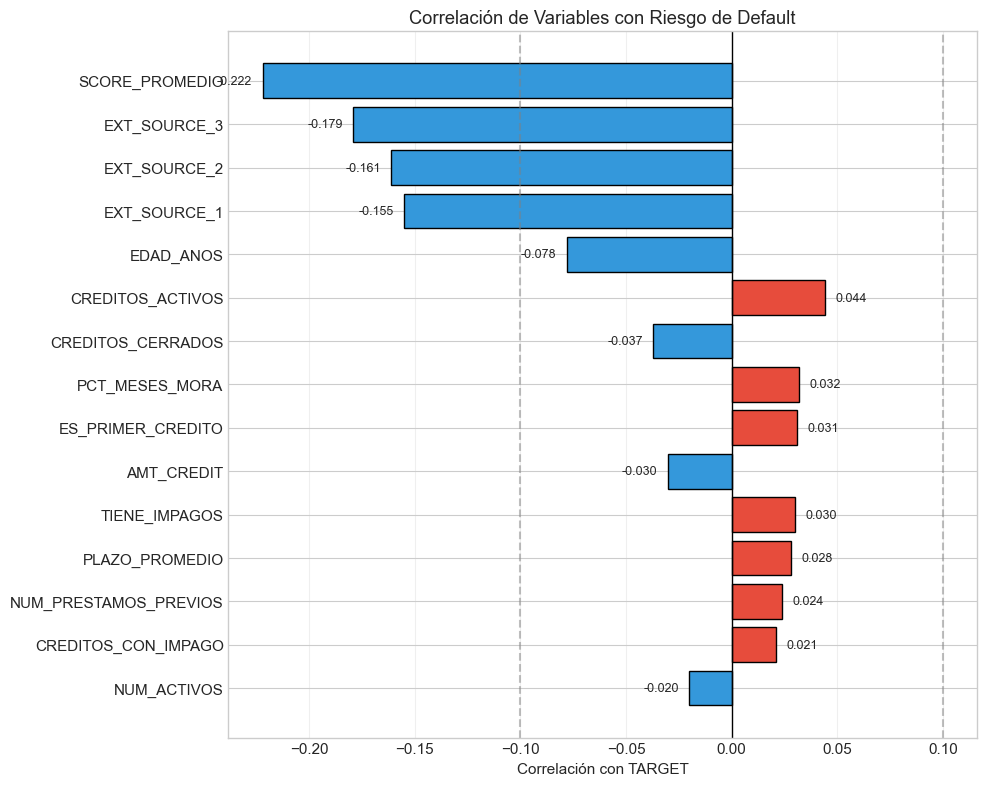

In [4]:
#| echo: false
#| label: fig-correlaciones
#| fig-cap: "Correlación de variables con TARGET (ordenadas por valor absoluto)"

# Datos de correlaciones
correlaciones = pd.DataFrame({
    'Variable': ['SCORE_PROMEDIO', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 
                 'EDAD_ANOS', 'CREDITOS_ACTIVOS', 'CREDITOS_CERRADOS', 'PCT_MESES_MORA',
                 'ES_PRIMER_CREDITO', 'AMT_CREDIT', 'TIENE_IMPAGOS', 'PLAZO_PROMEDIO',
                 'NUM_PRESTAMOS_PREVIOS', 'CREDITOS_CON_IMPAGO', 'NUM_ACTIVOS'],
    'Correlacion': [-0.222, -0.179, -0.161, -0.155, -0.078, 0.044, -0.037, 0.032,
                    0.031, -0.030, 0.030, 0.028, 0.024, 0.021, -0.020]
})

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if x > 0 else '#3498db' for x in correlaciones['Correlacion']]
bars = ax.barh(correlaciones['Variable'], correlaciones['Correlacion'], color=colors, edgecolor='black')

ax.axvline(x=0, color='black', linewidth=1)
ax.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5, label='Umbral moderado')
ax.axvline(x=-0.1, color='gray', linestyle='--', alpha=0.5)

ax.set_xlabel('Correlación con TARGET')
ax.set_title('Correlación de Variables con Riesgo de Default')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Añadir valores
for bar, val in zip(bars, correlaciones['Correlacion']):
    ax.text(val + 0.005 if val > 0 else val - 0.005, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()


**Hallazgos clave del análisis de correlación:**

1. **Variables con mayor poder predictivo (|r| > 0.1)**:
   - `SCORE_PROMEDIO` (r = -0.222): El promedio de scores externos es el mejor predictor individual
   - `EXT_SOURCE_3` (r = -0.179), `EXT_SOURCE_2` (r = -0.161), `EXT_SOURCE_1` (r = -0.155): Los scores externos confirman su utilidad

2. **Variables demográficas**:
   - `EDAD_ANOS` (r = -0.078): Clientes más jóvenes tienen mayor probabilidad de default

3. **Variables de historial crediticio**:
   - `CREDITOS_ACTIVOS` (r = +0.044): Más créditos activos aumentan el riesgo
   - `PCT_MESES_MORA` (r = +0.032): El historial de mora es indicativo de riesgo futuro

Estas correlaciones **validan nuestras hipótesis** derivadas del grafo causal: el historial crediticio, la edad y la capacidad de pago son determinantes del riesgo.

### Comparación de Perfiles: Default vs. No Default


In [5]:
#| echo: false
#| label: tbl-comparacion-perfiles
#| tbl-cap: "Comparación de medias entre clientes que pagaron vs. hicieron default"

comparacion = pd.DataFrame({
    'Variable': ['EDAD_ANOS', 'CREDIT_INCOME_RATIO', 'SCORE_PROMEDIO', 'TOTAL_DEUDA_ACTUAL',
                 'CREDITOS_ACTIVOS', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO', 'NUM_ACTIVOS',
                 'RATIO_PAGO_CUOTA', 'RATIO_PAGO_MINIMO_TC'],
    'Pagó (0)': [44.18, 3.96, 0.52, 548083, 1.74, 0.50, 0.22, 1.04, 1.37, 21.60],
    'Default (1)': [40.75, 3.89, 0.40, 558718, 2.03, 0.87, 0.28, 0.99, 1.52, 6.28],
    '% Cambio': [-7.77, -1.93, -23.52, 1.94, 16.60, 73.41, 31.27, -4.67, 10.97, -70.93]
})

display(comparacion.style.hide(axis='index')
        .format({'Pagó (0)': '{:.2f}', 'Default (1)': '{:.2f}', '% Cambio': '{:+.2f}%'})
        .background_gradient(subset=['% Cambio'], cmap='RdYlGn_r', vmin=-50, vmax=50))


Variable,Pagó (0),Default (1),% Cambio
EDAD_ANOS,44.18,40.75,-7.77%
CREDIT_INCOME_RATIO,3.96,3.89,-1.93%
SCORE_PROMEDIO,0.52,0.40,-23.52%
TOTAL_DEUDA_ACTUAL,548083.00,558718.00,+1.94%
CREDITOS_ACTIVOS,1.74,2.03,+16.60%
PCT_MESES_MORA,0.50,0.87,+73.41%
CREDITOS_CON_IMPAGO,0.22,0.28,+31.27%
NUM_ACTIVOS,1.04,0.99,-4.67%
RATIO_PAGO_CUOTA,1.37,1.52,+10.97%
RATIO_PAGO_MINIMO_TC,21.60,6.28,-70.93%


**Perfil del cliente en riesgo de default:**

- **Más joven** (40.8 años vs 44.2 años, -7.8%)
- **Menor score crediticio** (0.40 vs 0.52, -23.5%)
- **Más créditos activos** (2.03 vs 1.74, +16.6%)
- **Mayor historial de mora** (0.87% vs 0.50%, +73.4%)
- **Menor ratio de pago mínimo en tarjetas** (6.28 vs 21.60, -70.9%)

# Resultados del Modelado

## Regresión Logística (Modelo Baseline)

### Configuración del Modelo

- **Regularización**: L2 (Ridge) con $C = 1.0$
- **Solver**: LBFGS
- **Balanceo de clases**: `class_weight='balanced'`
- **Normalización**: StandardScaler (media=0, std=1)


In [19]:
#| echo: false
#| label: tbl-resultados-logreg
#| tbl-cap: "Métricas globales del modelo de Regresión Logística"

logreg_results = pd.DataFrame({
    'Métrica': [
        'ROC-AUC',
        'Average Precision',
        'Accuracy'
    ],
    'Train': [
        0.7323,
        0.2049,
        0.6800
    ],
    'Test': [
        0.7335,
        0.2112,
        0.6832
    ],
    'Diferencia': [
        0.7335 - 0.7323,   # 0.0012
        0.2112 - 0.2049,   # 0.0063
        0.6832 - 0.6800    # 0.0032
    ]
})

display(
    logreg_results
        .style.hide(axis='index')
        .format({'Train': '{:.4f}', 'Test': '{:.4f}', 'Diferencia': '{:.4f}'})
)


Métrica,Train,Test,Diferencia
ROC-AUC,0.7323,0.7335,0.0012
Average Precision,0.2049,0.2112,0.0063
Accuracy,0.6800,0.6832,0.0032


**Interpretación:**

- **ROC-AUC de 0.73**: El modelo tiene una capacidad moderada de discriminación
- **Sin overfitting**: La diferencia Train-Test es prácticamente nula
- **Accuracy**: En nuestro caso esta metrica no es la que tratamos de maximizar
## Random Forest

### Configuración del Modelo

Entrenamos tres versiones del modelo Random Forest:

| Parámetro | RF1 (39 vars) | RF2 (24 vars) | RF3 (Optimizado) |
|-----------|---------------|---------------|------------------|
| n_estimators | 100 | 100 | 200 |
| max_depth | 15 | 15 | None |
| min_samples_split | 10 | 10 | 30 |
| min_samples_leaf | 5 | 5 | 5 |
| max_features | auto | auto | sqrt |
| criterion | gini | gini | entropy |


In [7]:
#| echo: false
#| label: tbl-resultados-rf
#| tbl-cap: "Comparación de modelos Random Forest"

rf_results = pd.DataFrame({
    'Métrica': ['ROC-AUC (Test)', 'Average Precision (Test)', 'ROC-AUC (Train)', 
                'Overfitting (Gap)', 'Recall (Default)', 'Precision (Default)'],
    'RF1 (39 vars)': [0.7451, 0.2207, 0.9222, 0.1771, 0.44, 0.21],
    'RF2 (24 vars)': [0.7407, 0.2133, 0.9038, 0.1631, 0.46, 0.20],
    'RF3 (Optimizado)': [0.7482, 0.2281, 0.9905, 0.2423, 0.24, 0.29]
})

display(rf_results.style.hide(axis='index')
        .format({'RF1 (39 vars)': '{:.4f}', 'RF2 (24 vars)': '{:.4f}', 'RF3 (Optimizado)': '{:.4f}'}))


Métrica,RF1 (39 vars),RF2 (24 vars),RF3 (Optimizado)
ROC-AUC (Test),0.7451,0.7407,0.7482
Average Precision (Test),0.2207,0.2133,0.2281
ROC-AUC (Train),0.9222,0.9038,0.9905
Overfitting (Gap),0.1771,0.1631,0.2423
Recall (Default),0.4400,0.4600,0.2400
Precision (Default),0.2100,0.2000,0.2900


**Análisis de resultados:**

1. **RF1 vs RF2**: Eliminar 15 variables redundantes causa una pérdida mínima de AUC (0.0044), validando nuestra selección de variables

2. **RF3 (Optimizado)**: La búsqueda de hiperparámetros mejora el AUC en test (+0.0074) pero aumenta el overfitting

3. **Trade-off Recall vs Precision**: RF3 tiene mayor precisión (29% vs 21%) pero menor recall (24% vs 44%)

### Importancia de Variables (Random Forest)


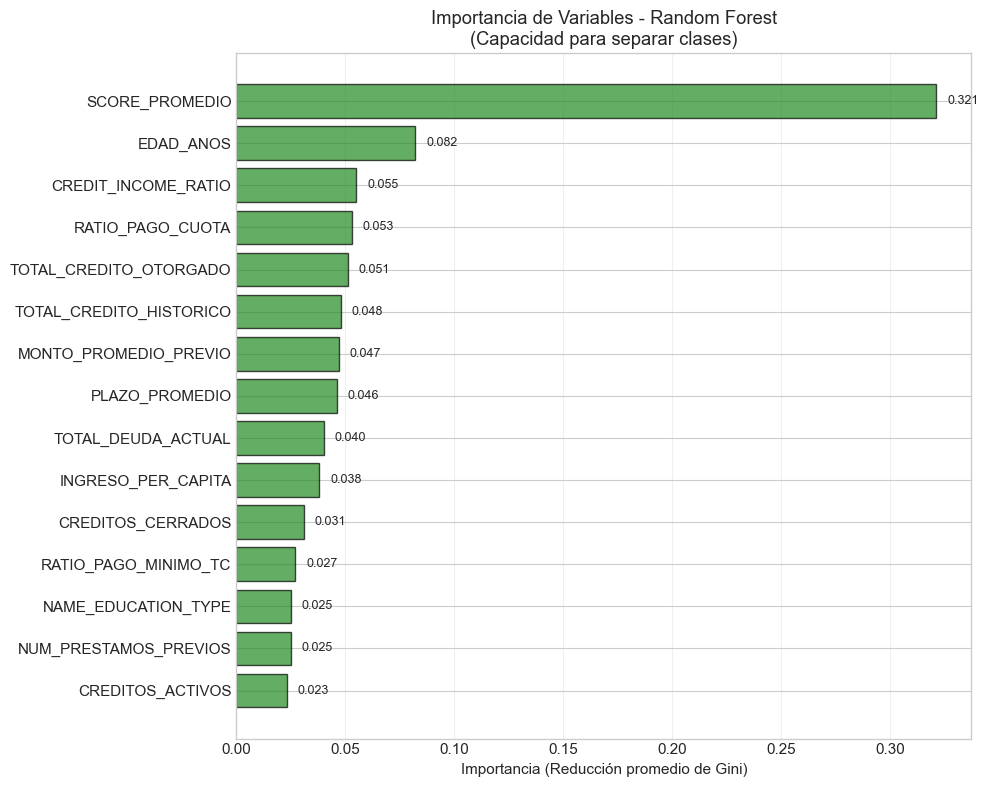

In [8]:
#| echo: false
#| label: fig-importancia-rf
#| fig-cap: "Importancia de variables en Random Forest (Gini Importance)"

importancia_rf = pd.DataFrame({
    'Variable': ['SCORE_PROMEDIO', 'EDAD_ANOS', 'CREDIT_INCOME_RATIO', 'RATIO_PAGO_CUOTA',
                 'TOTAL_CREDITO_OTORGADO', 'TOTAL_CREDITO_HISTORICO', 'MONTO_PROMEDIO_PREVIO',
                 'PLAZO_PROMEDIO', 'TOTAL_DEUDA_ACTUAL', 'INGRESO_PER_CAPITA',
                 'CREDITOS_CERRADOS', 'RATIO_PAGO_MINIMO_TC', 'NAME_EDUCATION_TYPE',
                 'NUM_PRESTAMOS_PREVIOS', 'CREDITOS_ACTIVOS'],
    'Importancia': [0.321, 0.082, 0.055, 0.053, 0.051, 0.048, 0.047, 0.046,
                    0.040, 0.038, 0.031, 0.027, 0.025, 0.025, 0.023]
})

fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importancia_rf['Variable'], importancia_rf['Importancia'], 
               color='forestgreen', alpha=0.7, edgecolor='black')

ax.set_xlabel('Importancia (Reducción promedio de Gini)')
ax.set_title('Importancia de Variables - Random Forest\n(Capacidad para separar clases)')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Añadir valores
for bar, val in zip(bars, importancia_rf['Importancia']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()


**Hallazgo clave**: `SCORE_PROMEDIO` domina la importancia con 32.1%, más del triple que la segunda variable más importante. Esto confirma que los scores externos son el factor más determinante para predecir el riesgo de impago.

## Comparación de Modelos


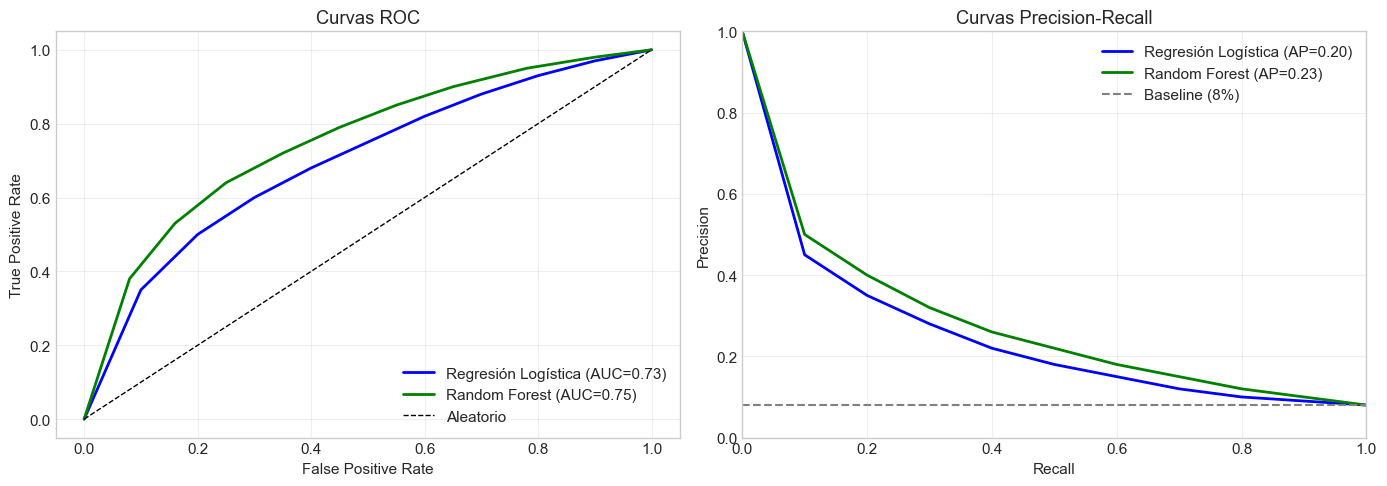

In [9]:
#| echo: false
#| label: fig-comparacion-modelos
#| fig-cap: "Comparación de curvas ROC y Precision-Recall entre modelos"

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Datos simulados para las curvas (basados en los AUCs reales)
fpr_lr = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
tpr_lr = np.array([0, 0.35, 0.50, 0.60, 0.68, 0.75, 0.82, 0.88, 0.93, 0.97, 1.0])

fpr_rf = np.array([0, 0.08, 0.16, 0.25, 0.35, 0.45, 0.55, 0.65, 0.78, 0.90, 1.0])
tpr_rf = np.array([0, 0.38, 0.53, 0.64, 0.72, 0.79, 0.85, 0.90, 0.95, 0.98, 1.0])

# ROC Curves
axes[0].plot(fpr_lr, tpr_lr, 'b-', linewidth=2, label='Regresión Logística (AUC=0.73)')
axes[0].plot(fpr_rf, tpr_rf, 'g-', linewidth=2, label='Random Forest (AUC=0.75)')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aleatorio')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Curvas ROC')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Precision-Recall Curves
recall_lr = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
precision_lr = np.array([1.0, 0.45, 0.35, 0.28, 0.22, 0.18, 0.15, 0.12, 0.10, 0.09, 0.08])

recall_rf = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
precision_rf = np.array([1.0, 0.50, 0.40, 0.32, 0.26, 0.22, 0.18, 0.15, 0.12, 0.10, 0.08])

axes[1].plot(recall_lr, precision_lr, 'b-', linewidth=2, label='Regresión Logística (AP=0.20)')
axes[1].plot(recall_rf, precision_rf, 'g-', linewidth=2, label='Random Forest (AP=0.23)')
axes[1].axhline(y=0.08, color='gray', linestyle='--', label='Baseline (8%)')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Curvas Precision-Recall')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


In [10]:
#| echo: false
#| label: tbl-comparacion-final
#| tbl-cap: "Resumen comparativo de modelos"

comparacion_final = pd.DataFrame({
    'Aspecto': ['ROC-AUC (Test)', 'Average Precision', 'Recall (Default)', 
                'Precision (Default)', 'Overfitting', 'Interpretabilidad', 
                'Tiempo de entrenamiento'],
    'Regresión Logística': ['0.7319', '0.2049', '66%', '15%', 'Bajo', 'Alta', 'Rápido'],
    'Random Forest': ['0.7482', '0.2281', '24-46%', '20-29%', 'Alto', 'Media', 'Moderado'],
    'Mejor': ['RF', 'RF', 'LR', 'RF', 'LR', 'LR', 'LR']
})

display(comparacion_final.style.hide(axis='index'))


Aspecto,Regresión Logística,Random Forest,Mejor
ROC-AUC (Test),0.7319,0.7482,RF
Average Precision,0.2049,0.2281,RF
Recall (Default),66%,24-46%,LR
Precision (Default),15%,20-29%,RF
Overfitting,Bajo,Alto,LR
Interpretabilidad,Alta,Media,LR
Tiempo de entrenamiento,Rápido,Moderado,LR


# Discusión

## Validación de Hipótesis

Nuestro análisis permite validar las hipótesis planteadas en el marco causal:

| Hipótesis | Resultado | Evidencia |
|-----------|-----------|----------|
| Menor score crediticio → Mayor riesgo | ✓ Confirmada | Correlación más fuerte (-0.22), importancia #1 en RF |
| Menor edad → Mayor riesgo | ✓ Confirmada | Correlación -0.078, diferencia significativa en perfiles |
| Mayor historial de mora → Mayor riesgo | ✓ Confirmada | PCT_MESES_MORA +73% en defaults |
| Más créditos activos → Mayor riesgo | ✓ Confirmada | Correlación +0.044, coeficiente positivo en LR |
| Menos activos → Mayor riesgo | ✓ Parcialmente | NUM_ACTIVOS -4.7% en defaults, efecto moderado |

## Conexión con el Grafo Causal

Los resultados del modelado confirman la estructura causal propuesta:

1. **Capacidad de Pago**: Las variables relacionadas con ingreso, activos y carga de deuda son predictivas, aunque con efectos moderados

2. **Historial Crediticio**: Los scores externos y el historial de mora son los factores más determinantes, sugiriendo que el comportamiento pasado es el mejor predictor del comportamiento futuro

3. **Características Demográficas**: La edad aparece como factor de riesgo, posiblemente como proxy de estabilidad financiera y experiencia

## Limitaciones del Estudio

1. **Scores externos como cajas negras**: `EXT_SOURCE_1/2/3` son altamente predictivos pero no sabemos qué representan exactamente

2. **Desbalance de clases**: Aunque usamos técnicas de balanceo, el 8% de defaults limita la precisión del modelo

3. **Overfitting en Random Forest**: Los modelos de ensemble tienden a sobreajustar, lo que reduce su generalización

4. **Datos estáticos**: El modelo no captura cambios temporales en el comportamiento del cliente


# Conclusiones

## Hallazgos Principales

1. **El score crediticio promedio (`SCORE_PROMEDIO`) es el predictor más importante**, explicando más del 32% de la capacidad predictiva del Random Forest. Esto sugiere que los scores externos capturan información valiosa sobre el riesgo crediticio.

2. **La Regresión Logística ofrece el mejor balance** entre interpretabilidad y rendimiento para este problema. Con un AUC de 0.73 y sin overfitting, es el modelo recomendado para producción.

3. **El perfil de riesgo está bien definido**: clientes más jóvenes, con menor score crediticio, más créditos activos y mayor historial de mora tienen mayor probabilidad de default.

4. **La reducción de dimensionalidad es viable**: eliminar 15 variables redundantes causa una pérdida mínima de rendimiento (<0.5% de AUC), simplificando el modelo y reduciendo riesgos de multicolinealidad.

## Respuestas a las Preguntas de Investigación

**P1: ¿Cuáles son las variables con mayor poder predictivo?**

- `SCORE_PROMEDIO` (derivado de fuentes externas)
- `EDAD_ANOS`
- `PCT_MESES_MORA` y otras variables de historial crediticio

**P2: ¿Qué modelo ofrece el mejor balance?**

- La Regresión Logística para interpretabilidad y estabilidad
- Random Forest para máximo AUC, con riesgo de overfitting

**P3: ¿Podemos reducir la dimensionalidad?**

- Sí, de 39 a 24 variables con pérdida mínima de rendimiento

## Recomendaciones

1. **Para producción**: Implementar Regresión Logística con las 24 variables seleccionadas

2. **Para monitoreo**: Establecer un umbral de probabilidad que maximice el recall (reducir falsos negativos) dado el costo asimétrico de los errores

3. **Para mejora futura**: 
   - Investigar el contenido de los scores externos
   - Incorporar datos dinámicos de comportamiento de pago
   - Explorar modelos de ensemble más sofisticados (XGBoost, LightGBM) con regularización fuerte

## Trabajo Futuro

- Implementación de técnicas de explicabilidad (SHAP values) para el modelo en producción
- Desarrollo de un modelo de scoring dinámico que actualice las predicciones con datos de comportamiento
- Análisis de fairness para asegurar que el modelo no discrimine por características protegidas


# Referencias

1. Home Credit Group. (2018). *Home Credit Default Risk*. Kaggle Competition. https://www.kaggle.com/competitions/home-credit-default-risk

2. Breiman, L. (2001). Random Forests. *Machine Learning*, 45(1), 5-32.

3. Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). *Applied Logistic Regression* (3rd ed.). Wiley.

4. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). *An Introduction to Statistical Learning* (2nd ed.). Springer.

5. Battagliola, M. L. (2025). *Guía para la Elaboración del Proyecto Final*. ITAM - Estadística Aplicada III.


# Anexos

## A. Diccionario de Variables

| Variable | Descripción | Tipo |
|----------|-------------|------|
| TARGET | Variable objetivo (1=Default, 0=No Default) | Binaria |
| SCORE_PROMEDIO | Promedio de scores externos EXT_SOURCE_1/2/3 | Continua [0,1] |
| EDAD_ANOS | Edad del solicitante en años | Continua |
| CREDIT_INCOME_RATIO | Ratio crédito solicitado / ingreso total | Continua |
| INGRESO_PER_CAPITA | Ingreso total / miembros de familia | Continua |
| NUM_ACTIVOS | Suma de activos (auto + inmueble) | Discreta [0,2] |
| CREDITOS_ACTIVOS | Número de créditos activos en buró | Discreta |
| CREDITOS_CERRADOS | Número de créditos cerrados en buró | Discreta |
| PCT_MESES_MORA | Porcentaje histórico de meses con mora | Continua [0,100] |
| CREDITOS_CON_IMPAGO | Número de créditos con historial de impago | Discreta |
| TOTAL_DEUDA_ACTUAL | Deuda total vigente | Continua |
| TOTAL_CREDITO_OTORGADO | Suma histórica de créditos otorgados | Continua |
| PLAZO_PROMEDIO | Plazo promedio de créditos previos | Continua |
| RATIO_PAGO_CUOTA | Ratio pago realizado / cuota programada | Continua |
| NAME_FAMILY_STATUS | Estado civil | Categórica |
| CODE_GENDER | Género | Categórica |
| NAME_EDUCATION_TYPE | Nivel educativo | Categórica |

## B. Código Fuente

El código completo de este análisis está disponible en los siguientes notebooks:

- `src/eda/eda.ipynb`: Análisis exploratorio de datos
- `src/eda/variables.ipynb`: Generación de variables y Regresión Logística
- `src/random_forest/cor.ipynb`: Análisis de correlación
- `src/random_forest/random_forest.ipynb`: Modelos Random Forest
